Calculate the flux density inside a mask containing the disk and its statistical uncertainty by taking the rms of the flux densities inside a number of non-overlapping masks around the central source, where there's only noise

To run after intensity_profile_radii_CLEAN.ipynb

In [2]:
import os, sys, time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import Colorbar
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
import matplotlib.patheffects as patheffects
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.io import fits
from astropy.visualization import (AsinhStretch, LinearStretch, ImageNormalize)

sys.path.append('../frank_fit')
import diskdictionary as disk
from myutils import Jybeam_to_Jysr, Jysr_to_Tb, Jysr_to_Tb_err, Jysr_to_Tb_RJ, Jysr_to_Tb_RJ_err
from gofish import imagecube  

arcsec = 1/3600 * np.pi/180
deg = np.pi/180

In [3]:
target = 'AA_Tau'

robust = -0.5

In [4]:
target_label = disk.disk[target]['label']
rout = disk.disk[target]['rout']
distance_pc = disk.disk[target]['distance']

maj_ticks = 2          # arcsec, spacing of the major ticks in figures
min_ticks = maj_ticks/4  # arcsec, spacing of the minor ticks in figures

# mask radius from CLEAN curve-of-growth method
r_mask = np.loadtxt(f'{target}_continuum_radii_CLEAN.txt')[1, 3]
# Otherwise you could use rout
# r_mask = rout

# load data
fitsimage = f'../frank_fit/CLEAN/robust{robust}/{target}_data_robust{robust}.fits'
dhdu = fits.open(fitsimage)
dimg, hd = np.squeeze(dhdu[0].data), dhdu[0].header

# beam parameters
bmaj, bmin, bPA = 3600 * hd['BMAJ'], 3600 * hd['BMIN'], hd['BPA']
beam_area = (np.pi * bmaj * bmin / (4 * np.log(2))) / (3600 * 180 / np.pi)**2

# parse coordinate frame indices into physical numbers
RA = 3600 * hd['CDELT1'] * (np.arange(hd['NAXIS1']) - (hd['CRPIX1'] - 1)) 
DEC = 3600 * hd['CDELT2'] * (np.arange(hd['NAXIS2']) - (hd['CRPIX2'] - 1))
dRA, dDEC = np.meshgrid(RA - disk.disk[target]['dx'], 
                        DEC - disk.disk[target]['dy'])
im_bounds = (dRA.max(), dRA.min(), dDEC.min(), dDEC.max())
angle_px_arcsec = np.abs(hd['CDELT1']*3600)
freq = hd['CRVAL3']

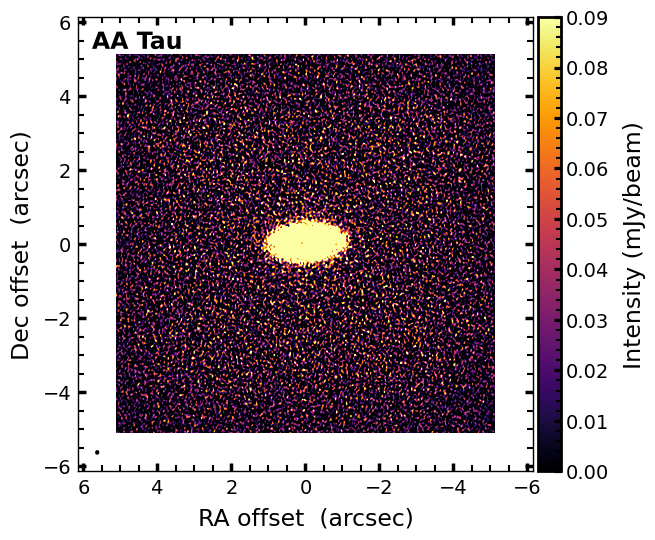

In [5]:
fig = plt.figure(figsize=(7.0, 5.9))
ax = fig.add_subplot(111)

contimage = imagecube(fitsimage, FOV=27.)
contimage_shift = contimage.shift_image(x0=disk.disk[target]['dx'], y0=disk.disk[target]['dy'])
im = plt.imshow(contimage_shift*1e3, extent=contimage.extent, origin='lower', vmin=0, vmax=0.09, cmap='inferno')

# Write source name
ax.text(0.03, 0.93, s=target_label,
        transform=ax.transAxes, color='k', fontsize=17, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

# limits, labeling
lim_img = 1.1
ax.set_xlim(contimage.extent[0]*lim_img, contimage.extent[1]*lim_img)
ax.set_ylim(contimage.extent[2]*lim_img, contimage.extent[3]*lim_img)

# beam
beam = Ellipse((contimage.extent[0] + 0.1*contimage.extent[0], 
                contimage.extent[1] + 0.1*contimage.extent[1]), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax.add_artist(beam)

# add scalebars
cbar = fig.colorbar(im, ax=ax, pad=0.01, location='right', fraction=0.0472)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar.set_label('Intensity (mJy/beam)', labelpad=10, fontsize = 17)
cbar.ax.minorticks_on()

# axes style
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))
ax.yaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(min_ticks)) 
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)

In [6]:
# select the centers of the masks in order to have the highest number possible of non-overlapping ellispes around the central source
centers = np.linspace(-3, 3, 2)


x, y = np.meshgrid(centers, centers)
points = np.array([(xi, yi) for xi, yi in zip(x.flatten(), y.flatten())])
dim = points.shape[0]

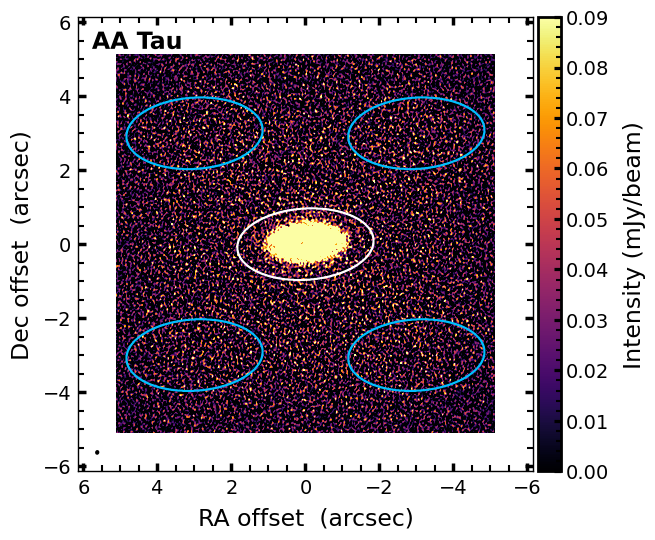

In [7]:
fig = plt.figure(figsize=(7.0, 5.9))
ax = fig.add_subplot(111)

contimage = imagecube(fitsimage, FOV=27.)
contimage_shift = contimage.shift_image(x0=disk.disk[target]['dx'], y0=disk.disk[target]['dy'])
im = plt.imshow(contimage_shift*1e3, extent=contimage.extent, origin='lower', vmin=0, vmax=0.09, cmap='inferno')

# Write source name
ax.text(0.03, 0.93, s=target_label,
        transform=ax.transAxes, color='k', fontsize=17, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=5, foreground="w")])

# limits, labeling
ax.set_xlim(contimage.extent[0]*lim_img, contimage.extent[1]*lim_img)
ax.set_ylim(contimage.extent[2]*lim_img, contimage.extent[3]*lim_img)

# beam
beam = Ellipse((contimage.extent[0] + 0.1*contimage.extent[0], 
                contimage.extent[1] + 0.1*contimage.extent[1]), bmaj, bmin, angle=90-bPA, 
                edgecolor='k', lw=1.5, facecolor='none', hatch='/////')
ax.add_artist(beam)

# add scalebars
cbar = fig.colorbar(im, ax=ax, pad=0.01, location='right', fraction=0.0472)
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(which='major', labelsize=14,width=2.3, length=5,direction='in')
cbar.ax.tick_params(which='minor', labelsize=14,width=1.5, length=3.5,direction='in')
cbar.set_label('Intensity (mJy/beam)', labelpad=10, fontsize = 17)
cbar.ax.minorticks_on()

# axes style
ax.xaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.xaxis.set_minor_locator(MultipleLocator(min_ticks))
ax.yaxis.set_major_locator(MultipleLocator(maj_ticks))
ax.yaxis.set_minor_locator(MultipleLocator(min_ticks)) 
ax.tick_params(which='major',axis='both',right=True,top=True, labelsize=14, pad=5,width=2.5, length=6,direction='in',color='k')
ax.tick_params(which='minor',axis='both',right=True,top=True, labelsize=14, pad=5,width=1.5, length=4,direction='in',color='k')
ax.set_xlabel('RA offset  (arcsec)', fontsize = 17, labelpad=7)
ax.set_ylabel('Dec offset  (arcsec)', fontsize = 17, labelpad=7)


for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(1)

# compute flux and its rms noise
flux_noise = []

# check if (0, 0) exists in points
has_center_point = np.any((points[:, 0] == 0) & (points[:, 1] == 0))
flux_disk_computed = False  # flag to avoid computing it multiple times

for i in range(dim):
    x0, y0 = points[i, 0], points[i, 1]
    
    mask = contimage.get_mask(r_min=0, r_max=r_mask,
                              mask_frame='disk',
                              inc=disk.disk[target]['incl'],
                              PA=disk.disk[target]['PA'],
                              x0=x0, y0=y0)

    data = contimage_shift[mask] * 1e3 * (angle_px_arcsec**2 / contimage._calculate_beam_area_arcsec())

    if has_center_point:
        if x0 == 0 and y0 == 0:
            flux_disk = np.sum(data)
            plt.contour(mask, extent=contimage.extent, origin='lower', colors='w')
        else:
            flux_noise.append(np.sum(data))
            plt.contour(mask, extent=contimage.extent, origin='lower', colors='deepskyblue')
    else:
        # only compute once using center (0,0)
        if not flux_disk_computed:
            mask_center = contimage.get_mask(r_min=0, r_max=r_mask,
                                             mask_frame='disk',
                                             inc=disk.disk[target]['incl'],
                                             PA=disk.disk[target]['PA'],
                                             x0=0.0, y0=0.0)
            data_center = contimage_shift[mask_center] * 1e3 * (angle_px_arcsec**2 / contimage._calculate_beam_area_arcsec())
            flux_disk = np.sum(data_center)
            plt.contour(mask_center, extent=contimage.extent, origin='lower', colors='w')
            flux_disk_computed = True

        flux_noise.append(np.sum(data))
        plt.contour(mask, extent=contimage.extent, origin='lower', colors='deepskyblue')

flux_noise = np.asarray(flux_noise)
error_flux = np.std(flux_noise)

In [8]:
print(f'Integrated flux of {target}: {flux_disk:.2f} ± {error_flux:.2f} mJy')

Integrated flux of AA_Tau: 190.44 ± 0.37 mJy
